# Introduction to Regression Methods

This post will be a walkthrough on fitting, feature selection, making inferences and evaluating assumptions using multiple regression in the context of predicting housing prices using a dataset provided by Kaggle.

## Model Assumptions

First and foremost, we begin with the assumptions of linear regression models.

 -The datapoints should be independent from one another.
 -The independent variables (i.e. features of our data) should not be extremely correlated
 -The relationship between the mean of our dependent variable conditioned on a particular set of independent feature
  values is linear. I.e. if <b>x</b> is our feature vector, then the dependent variable y should be expressable as a
  dot product between <b>x</b> and our coefficient vector.
 -(Optional for inference) The variance of y should be independent of our <b>x</b> values. If this assumption is
  violated, then the model coefficients we have estimated will have underestimated standard errors, thus making our
  inferences about the significance of those coefficients unreliable. The confidence intervals we generate for each
  prediction will also be too "narrow". However, if the goal is purely deterministic prediction, then this assumption
  need not hold.

## Exploring the data

Exploring our data will allow us to get an idea of how it is distributed, which features may be informative and will prepare us for adding value to our models through the use of heuristics.

Before we can start exploring the data though, it helps to do some preliminary cleaning. In the case of this dataset, this means filling in missing values. There are many ways to do this and really stem from where and how the data is being generated. For continuous features which are usually obtained through measurements, we may interpret missing data as unavailability and not indicative of any special categorization or characteristics of the datapoint; in this case, we may fill it in with the mean of the feature. For numerical features that are discrete and perhaps indicate a count of something or a categorization, a missing value may make more sense as 0 or a category of "Missing". Other fill in methods include using the median, mode, discarding the feature and training a separate model to predict the missing feature value.

In [2]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('data/kaggle_housing_train.csv')

#move house prices to a separate vector and log them to get them normally distributed
prices = df_train['SalePrice']
log_prices = np.log(prices)
df_train = df_train.drop('SalePrice', axis=1)

df_test = pd.read_csv('data/kaggle_housing_test.csv')

#concatenate training and test data for now so we don't have to do processing twice everytime
all_data = pd.concat((df_train, df_test))


#look at the features with missing values
print("{} datapoints".format(len(all_data)))

#break up for categorical and numerical features for processing
all_num = all_data.select_dtypes(exclude=['object'])
all_cat = all_data.select_dtypes(include=['object'])

missing_feats = np.sum(all_data.isnull(), axis=0)
missing_featnames = all_data.columns[missing_feats != 0]
missing_num_feats = all_num.columns[all_num.columns.isin(missing_featnames)]
missing_cat_feats = all_cat.columns[all_cat.columns.isin(missing_featnames)]

missing_feats[missing_feats > 0]

2919 datapoints


MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [3]:
#There are some numericals that are continuous and others discrete/categorical encodings
#We can be pretty sure which are which when we look at the unique counts
all_data.loc[:,missing_num_feats].apply(lambda x: len(x.unique()))

LotFrontage      129
MasVnrArea       445
BsmtFinSF1       992
BsmtFinSF2       273
BsmtUnfSF       1136
TotalBsmtSF     1059
BsmtFullBath       5
BsmtHalfBath       4
GarageYrBlt      104
GarageCars         7
GarageArea       604
dtype: int64

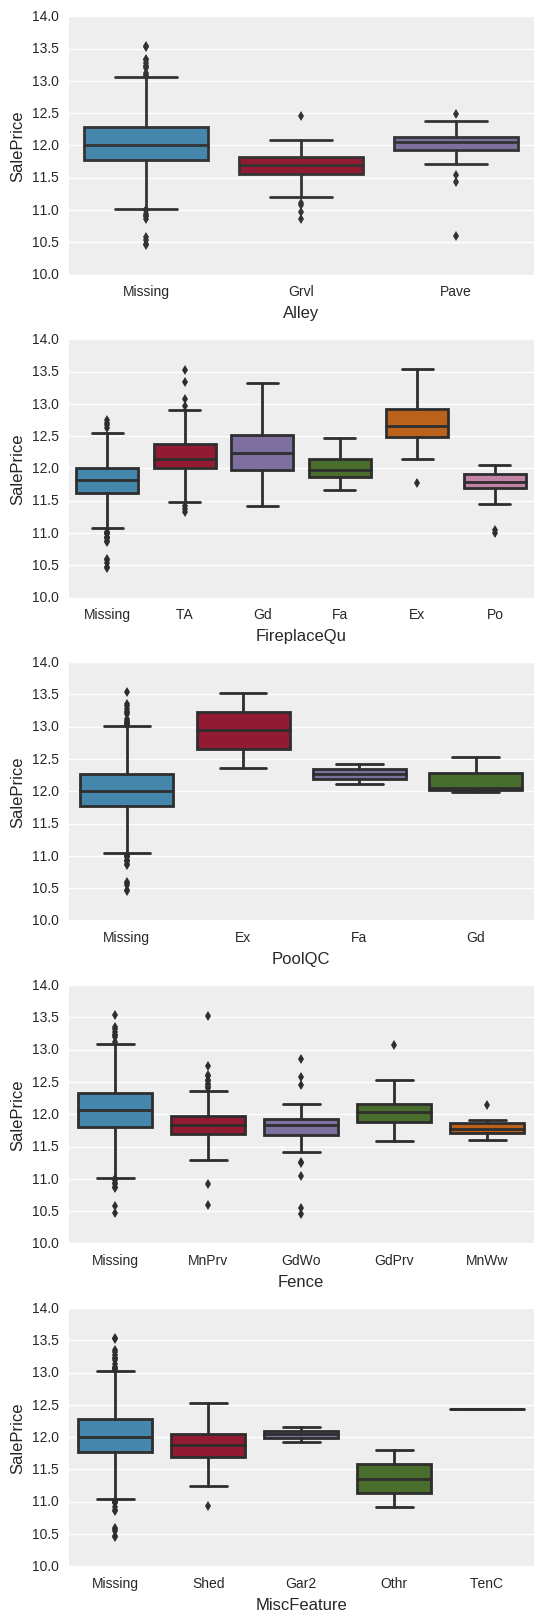

In [4]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.style.use('bmh')

#plot features with a lot of missing values to see if they have any value
#if not we should just drop them
excessive_missing = all_data.columns[missing_feats > 1400]
fig, axes = plt.subplots(nrows=len(excessive_missing), ncols=1, figsize=(6, len(excessive_missing)*4))
for ax, f in zip(axes, excessive_missing):
    if len(all_data[f].unique()) > 10:
        plt.scatter(df_train[f].fillna(0), log_prices, color='g', ax=ax)
    else:
        sns.boxplot(df_train[f].fillna('Missing'), log_prices, ax=ax)
plt.subplots_adjust(hspace=.25)

It seems there's some difference in sales price for properties with missing values vs. those without. There are more formal ways to test this, e.g. with ANOVA. But for our demonstrative purposes, boxplotting them should be enough. We fill in the missing values next.

In [5]:
#For continuous, fill missing values with mean
#For discrete numericals, they seem to be count data, so we can fill these in with 0
all_data.loc[:, missing_num_feats] = all_data.loc[:, missing_num_feats].apply(lambda x: x.fillna(x.mean()) 
                                                                                      if len(x.unique()) > 100 
                                                                                      else x.fillna(0))
#For categoricals, add a "missing" value to the columns which will be dummified later as an extra category
all_data.loc[:, missing_cat_feats] = all_data.loc[:, missing_cat_feats].apply(lambda x: x.fillna('Missing'))

## Looking at Time Series Data

This data does have transaction month and year of sale values. Before we begin exploring other features and fitting our model, it is important to make sure our data is not "autocorrelated" (i.e. points are independent of past points). If this is not the case, then we have to "stationarize" our data.

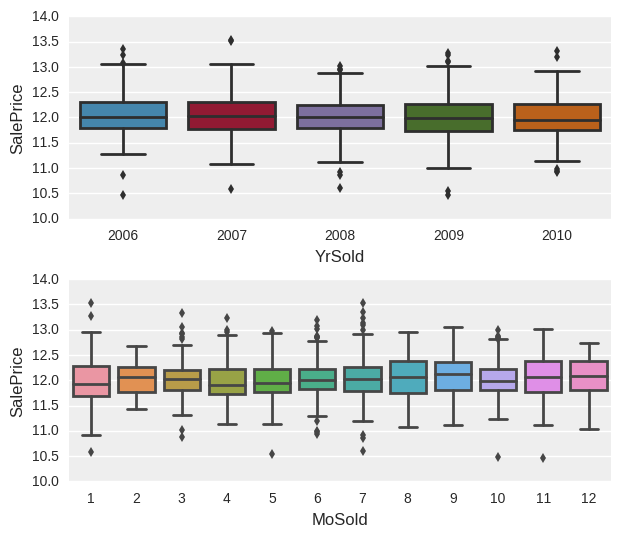

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 2*3))
sns.boxplot(df_train['YrSold'], log_prices, ax=axes[0])
sns.boxplot(df_train['MoSold'], log_prices, ax=axes[1])
plt.subplots_adjust(hspace=.3)

Whew, there doesn't seem to be any major trends, correlations or seasonalities between sales over time. Since the real estate market is not as transparent and liquid as other assets such as equities, commodities and bonds, it makes sense that sales at one point in time do not siginificantly influence sales later. If our data was more concentrated in one region with significant development, then we probably would have seen more of a trend. 

## Normalizing our Data

It also helps to first normalize our independent variables. This is not a necessary assumption for linear regression; however, if our data is highly skewed, we want to transform it in such a way that a unit increase of 10 from 100 to 110 has the same effect on the dependent variable as an increase from 10000 to 10010.

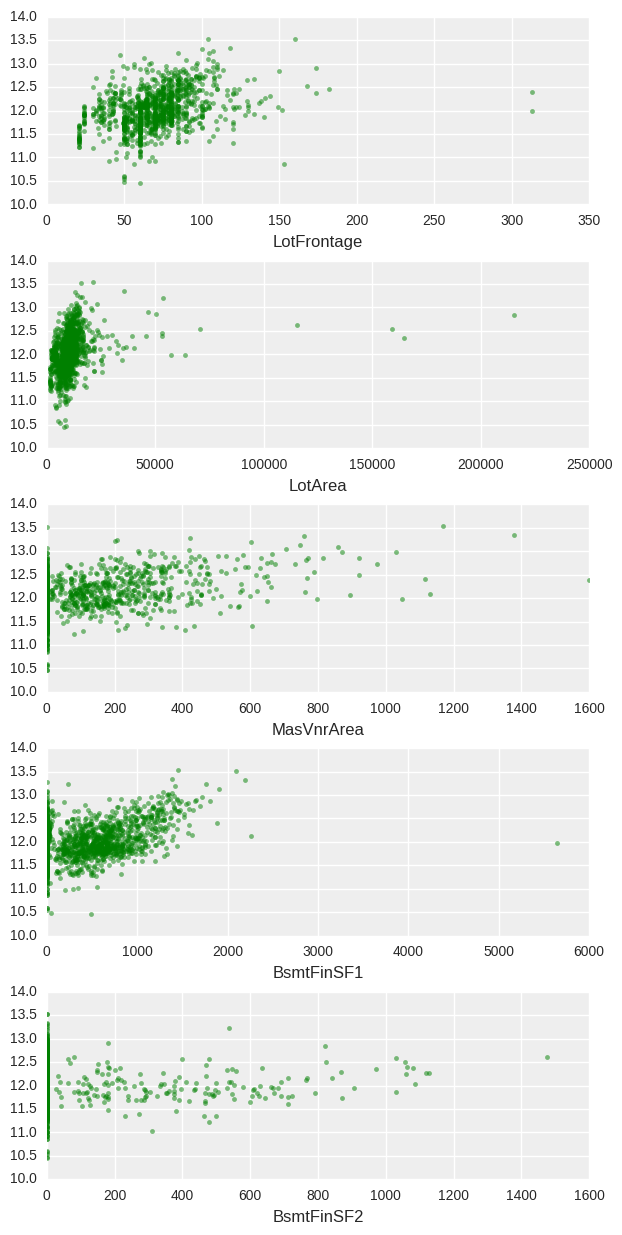

In [7]:
from scipy.stats import skew

#Variables with more than 100 unique values are likely continuous
continuous_feats = [f for f in all_data.columns if len(all_data[f].unique()) > 30]
discrete_feats = [f for f in all_data.columns if len(all_data[f].unique()) <= 30]

#For continuous features, log(1+x) transform the feature if the skew is big enough
skewed_feats = [f for f in continuous_feats if skew(all_data[f]) > .75]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(7, 15))

for i, f in enumerate(skewed_feats[:5]):
    axes[i].plot(df_train[f], log_prices, '.', color='g', alpha=.5)
    axes[i].set_xlabel(f)
plt.subplots_adjust(hspace=.3)

In [8]:
#Notice that for these features, the change in log of sale price as the feature value increases become less pronounced
#This is non-linear in behavior and calls for a log(1+x) transformation

all_data.loc[:, skewed_feats] = all_data.loc[:, skewed_feats].apply(lambda x: np.log1p(x))

## Gold at the End of the Rainbow

Feature engineering and, on a lesser scale, feature selection are both art as much as science. If we think of machine learning as attempting to approximate some function over an extremely large set of dimensions, the part where we humans can still contribute some value is in providing some structure to make the function search easier.

There are a number of heuristics and statistics that can be used to quantify the predictive value of our features. We can use ANOVA to test the statistical significance of a categorical variable's relationship with the dependent mean. Other measures of dependence between two variables include correlation and mutual information score. As usual, visualizations can also help.

Since our dependent variable is continuous, it makes sense to use correlation and ANOVA.

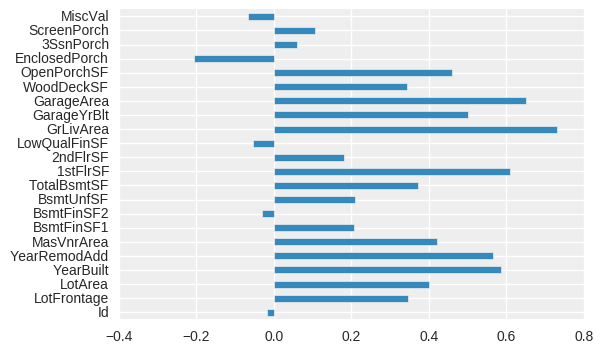

In [9]:
from scipy.stats import f_oneway, pearsonr

#reset the train and test dataframes to views of all_data since we did our preprocessing on all_data only
df_train = all_data[:len(df_train)]
df_test = all_data[len(df_train):]

#calculate pearson's correlation for continuous features and anova p-values for discrete features
feat_corrs = df_train.loc[:, continuous_feats].apply(lambda x: pearsonr(x, log_prices)[0])
feat_corrs.plot(kind='barh')

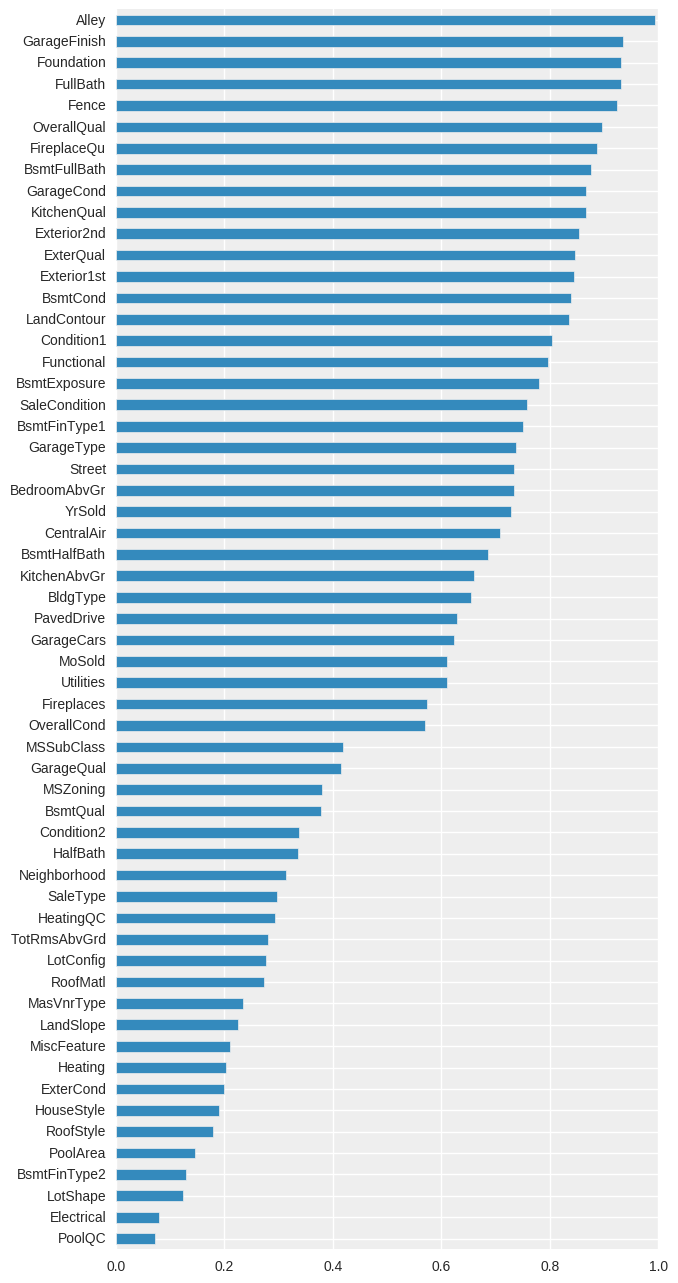

In [10]:
def anova(f_name):
    #concatenate the prices and feature and then group them and extract the grouped prices as a list of lists
    grouped_prices = pd.concat((df_train[f_name], log_prices), axis=1).groupby(f_name).groups.values()
    #split the list of lists of prices and pass into scipy's one way anova function which returns a F-statistic and p-value
    return f_oneway(*grouped_prices)[1]

feat_anova_pvalues = pd.Series({f: anova(f) for f in discrete_feats}).sort_values()
#lower pvalues means more statistical significance so we plot 1-pvalues 
feat_anova_pvalues.plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches((7, 16))

A majority of the features do not show any statistically significant effect on the mean of the logged sale price. Before we decide to exclude any of these, let's visualize them to make sure.

Index([u'LotShape', u'BsmtFinType2', u'PoolArea', u'RoofStyle', u'HouseStyle',
       u'ExterCond', u'Heating', u'MiscFeature', u'LandSlope', u'MasVnrType',
       u'RoofMatl', u'LotConfig', u'TotRmsAbvGrd', u'HeatingQC', u'SaleType',
       u'Neighborhood', u'HalfBath', u'Condition2', u'BsmtQual', u'MSZoning',
       u'GarageQual', u'MSSubClass', u'OverallCond', u'Fireplaces',
       u'Utilities', u'MoSold', u'GarageCars', u'PavedDrive', u'BldgType',
       u'KitchenAbvGr', u'BsmtHalfBath', u'CentralAir', u'YrSold',
       u'BedroomAbvGr', u'Street', u'GarageType', u'BsmtFinType1',
       u'SaleCondition', u'BsmtExposure', u'Functional', u'Condition1',
       u'LandContour', u'BsmtCond', u'Exterior1st', u'ExterQual',
       u'Exterior2nd', u'KitchenQual', u'GarageCond', u'BsmtFullBath',
       u'FireplaceQu', u'OverallQual', u'Fence', u'FullBath', u'Foundation',
       u'GarageFinish', u'Alley'],
      dtype='object')


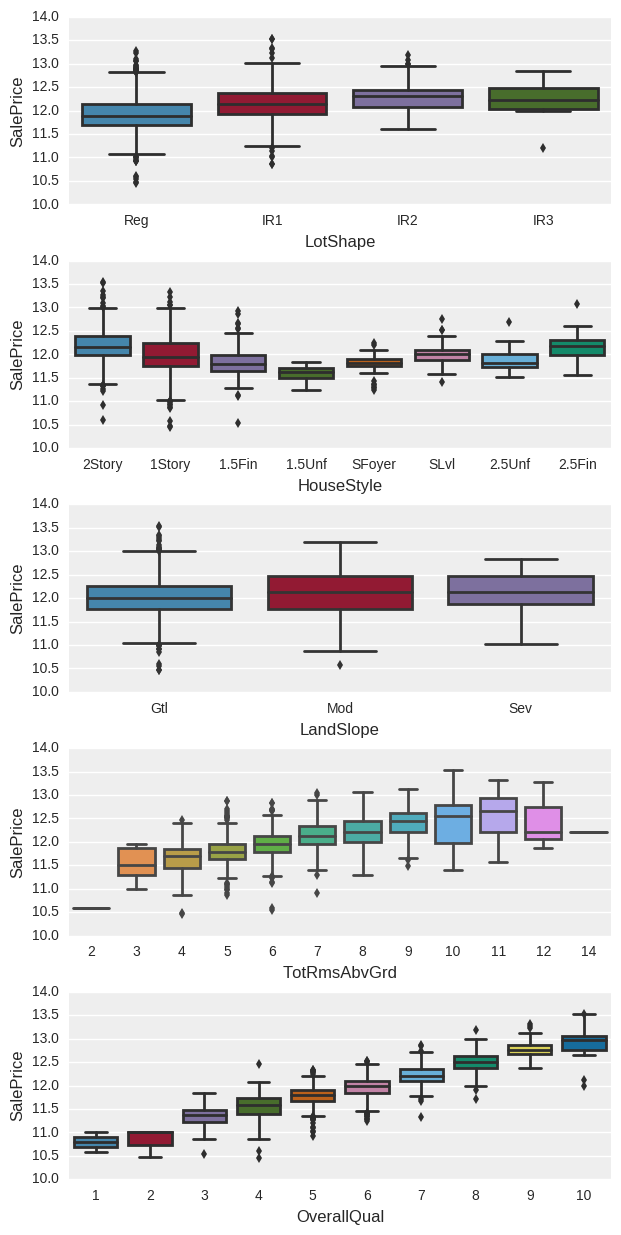

In [11]:
insig_discrete_feats = feat_anova_pvalues[feat_anova_pvalues > .1].index
print(insig_discrete_feats)
feats_to_plot = ['LotShape', 'HouseStyle', 'LandSlope', 'TotRmsAbvGrd', 'OverallQual']
#For the sake of space we will only plot five of them here which some obvious non-affectors and affectors and subtle ones
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(7, 5*3))
for ax, f in zip(axes, feats_to_plot):
    sns.boxplot(df_train[f], log_prices, ax=ax)
plt.subplots_adjust(hspace=.3)

Thus, we can see that features like "overall quality" and "total rooms above ground", despite having statistically insignificant relationships with the mean of the logged sale price, should obviously be included in the regression model based on these visualizations. I will skip box-plotting all of these features and picking out the ones we want to include. However, the lesson to be learned here is that visualizations such as histograms and boxplots are handy tools to help understand bivariate relationships alongside statistical tests.

## Finding the Right Fit

Now that we have an idea of which continuous and categorical features we want to include/exclude, we can begin playing around with fitting a regression model. A naive approach would be to throw in all of our features, fit the model and then Viola! record our R^2, and start writing the abstract for our new research paper.

However, if we have any goals other than purely fitting our labeled data, this approach will not work. While it is true that using as many features as we can will inevitably allow us to explain more and more of the variance of the data we have, the model we are fitting will not necessarily generalize well to unlabeled data we get in the future. In other words, we want to make sure our model fits to the signal and not the noise. Finally, if we also want to use our model to conduct inference about the effects of features on the dependent variable, having "noise" features will dampen the statistical significance of the effects of the actual important features.

But how do we actually find the best feature set to use? Well, one common way is called "stepwise regression", where a greedy approach is taken to select the next feature to add to our model based on how much the add reduces our target error metric. Analogously, we can also start with the full model and pick off the least valuable feature one at a time.

What metric do we use to do this? Well, we can't use $R^2$ because $R^2$ will always decrease/increase as we add/remove more features. We need a metric that will not only account for the explained variance, but also penalize for the size of the model. Thus, finding the optimal feature set becomes a matter of finding the best balance between explanatory power and model complexity. Common metrics for this are the Akaike Information Criterion, and the Bayesian Information Criterion.

Since stepwise regression involves fitting n + (n-1) + (n-2) + ... models in order to find the optimal feature set, we will be fitting on the order of $O(n^2)$ models, where n is the number of features. For the sake of brevity we will also skip doing that here. Instead, I will introduce a "cheaper" way to select features called regularization.

## Lasso and the Ridge

Regularization in machine learning/statistics is the idea of introducing prior information in order to help solve the problem. This can take many forms; for example, if we are trying to determine the probability distribution of a bunch of weather patterns, e.g. snow, rain, sunny, storm etc., a naive approach would be to just take the empirical frequency. But what about rare events that we don't see during our "training period"? Do we set those as 0 probability? One way to apply regularization to this problem is to set a prior for each event, e.g. they are each equally likely with 1/n probability of occuring.

In regression, we are trying to find the coefficients of the linear regression equation that will minimize the average sum of the squared errors of our predictions. Namely, this is the function we are minimizing to arrive at our coefficients:

$$ f(\theta) = \frac{1}{2n}\sum_{i=1}^m ({y_i - \theta x_i})^2 $$

This is called the "cost" or "risk" function in machine learning. We get our model by trying to optimize this function. To incorporate an additional cost for large models and extreme coefficients which will tend to overfit our training data we can add what are called the "norms" of our coefficient vector:

$$ f(\theta) = \frac{1}{2n}\sum_{i=1}^m({y_i - \theta x_i})^2 + \alpha \sum_{j=1}^n {\theta^{(j)}}^2 $$

Where m is the number of points we have and n is the length of our feature vector. The right part is called the L2-norm or is basically the Euclidean distance of the feature vector from the origin. Minimizing this cost function is what gets us the Ridge Regression procedure. Here, $\alpha$ is called "the learning rate" and determines how much we want to emphasize the punishment for larger models.

Alternatively, we can add what is called the "L1-norm" instead of the "L2-norm" which is:

$$ \alpha \sum_{j=1}^n \left|{\theta^{(j)}}\right| $$

Fitting that cost function will give us the Lasso Regression procedure. In both procedures, features which have large effects on the dependent variable will be favored over features with small effects. However, there is an important distinction between Lasso and Ridge that will be covered later.

We will now fit our data by optimizing both cost functions and pick the best generalizing model. However, before we do that, we first must pick which learning rate to use. This is known as hyper parameter tuning and is done using a process called cross-validation, which leaves out some training data when fitting the model and then choosing the parameter which produces the model that best fits the left out training data. This is meant to approximate how well the hyper parameter generalizes to unseen data.

In [30]:
#Get dummy columns for our categorical variables.

all_data = pd.get_dummies(all_data)
df_train = all_data[:len(df_train)]
df_test = all_data[len(df_test):]

#import sklearn's linear models and cross validation
import math
import sklearn.linear_model as lm
import sklearn.cross_validation as cv

#Make our own kfold cross validation function to illustrate how the process works
def reg_cv_kfold(model_type, X, y, alphas, cost_func, numfolds=4, seed=1):
    
    #initialize the lists to store our avg errors for each iteration of cv for each of our alphas
    #initialize a variable to track our best alpha and our smallest cv
    train_errs = []
    test_errs = []
    min_cv_err = 10**10
    best_alpha = 0
    
    #generate the k folds which will be used to split our training data into a training set and a pseudo test set
    folds = cv.KFold(len(X), n_folds=numfolds, random_state=seed)
    
    for i, a in enumerate(alphas):
        train_err = 0
        test_err = 0
        #we will train the regularized model parameterized by each alpha k times, each time leaving out a different fold
        for train, test in folds:
            model = model_type(alpha=a, random_state=seed)
            model.fit(X.ix[train], y[train])

            #sum the training/testing error which will later be averaged and stored for each alpha
            train_predictions = model.predict(X.ix[train])
            train_err += cost_func(train_predictions, y[train])

            test_predictions = model.predict(X.ix[test])
            test_err += cost_func(test_predictions, y[test])
        train_errs.append(train_err/len(folds))
        test_errs.append(test_err/len(folds))
        
        #check if we have a new minimum test error
        if test_err/len(folds) < min_cv_err:
            min_cv_err = test_err/len(folds)
            best_alpha = a

    return best_alpha, min_cv_err, test_errs, train_errs

#define a cost function; this the cost function that will be used by the kaggle evaluation
#not that y and predictions are already logged here; i.e. the model predicts logged prices and not actual prices
def mse(y, preds):
    return np.sum((y-preds)**2) / len(y)

Smallest Lasso MSE: 0.0152259834983
Smallest Ridge MSE: 0.0161832787465


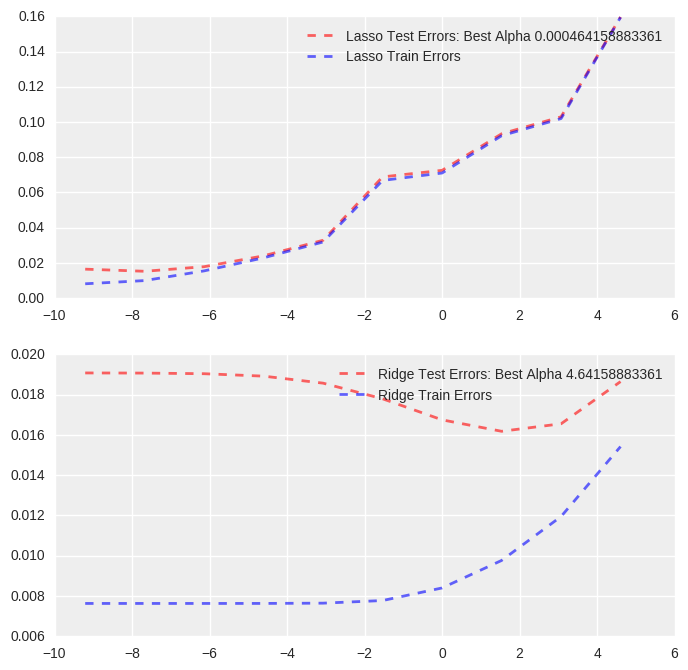

In [33]:
#fit a lasso and ridge regression with all features
alphas = np.logspace(-4, 2, 10)
lass_a, lass_min_cv, lass_test_errs, lass_train_errs = reg_cv_kfold(lm.Lasso, df_train, log_prices, alphas, mse)

ridg_a, ridg_min_cv, ridg_test_errs, ridg_train_errs = reg_cv_kfold(lm.Ridge, df_train, log_prices, alphas, mse)

fig, axes = plt.subplots(nrows=2, figsize=(8, 8))
axes[0].plot(np.log(alphas), lass_test_errs, '--', color='r', alpha=.6)
axes[0].plot(np.log(alphas), lass_train_errs, '--', color='b', alpha=.6)
axes[0].legend(['Lasso Test Errors: Best Alpha {}'.format(lass_a), 'Lasso Train Errors'])
print("Smallest Lasso MSE: {}".format(lass_min_cv))

axes[1].plot(np.log(alphas), ridg_test_errs, '--', color='r', alpha=.6)
axes[1].plot(np.log(alphas), ridg_train_errs, '--', color='b', alpha=.6)
axes[1].legend(['Ridge Test Errors: Best Alpha {}'.format(ridg_a), 'Ridge Train Errors'])
print("Smallest Ridge MSE: {}".format(ridg_min_cv))

It seems that we have pretty good and similar results using lasso and ridge. However, remember the distinction between the two I mentioned? Well, it turns out that the L1-norm which Lasso optimizes causes unimportant features to have their coefficients scaled down to 0, whereas this is not the case for Ridge. In other words, Lasso Regression automatically feature selects for us. Talk about a catch!

Let's look at how many features lasso selected for us, as well as what the residuals for both models look like.

Lasso selected 113 features and discarded 199
Training Errors - Lasso: 0.010736560366, Ridge: 0.0102507190062


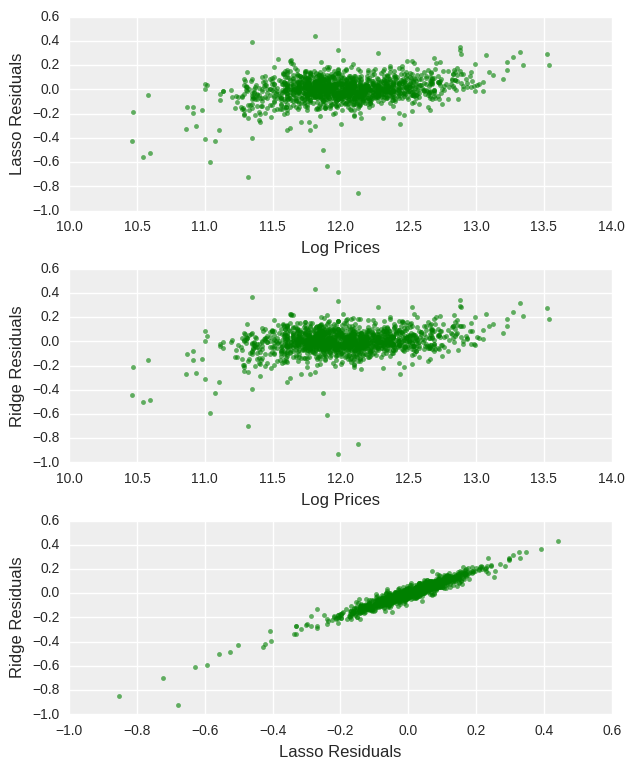

In [39]:
lass_reg = lm.Lasso(alpha=lass_a)
lass_reg.fit(df_train, log_prices)
print("Lasso selected {} features and discarded {}".format(np.sum(lass_reg.coef_ != 0), np.sum(lass_reg.coef_ == 0)))

ridg_reg = lm.Ridge(alpha=ridg_a)
ridg_reg.fit(df_train, log_prices)

lass_preds = lass_reg.predict(df_train)
ridg_preds = ridg_reg.predict(df_train)

lass_resids = log_prices - lass_preds
ridg_resids = log_prices - ridg_preds

print("Training Errors - Lasso: {}, Ridge: {}".format(mse(log_prices, lass_preds), mse(log_prices, ridg_preds)))

fig, axes = plt.subplots(nrows=3, figsize=(7, 9))

axes[0].plot(log_prices, lass_resids, '.', color='g', alpha=.6)
axes[0].set_ylabel('Lasso Residuals')
axes[0].set_xlabel('Log Prices')

axes[1].plot(log_prices, ridg_resids, '.', color='g', alpha=.6)
axes[1].set_ylabel('Ridge Residuals')
axes[1].set_xlabel('Log Prices')

axes[2].plot(lass_resids, ridg_resids, '.', color='g', alpha=.6)
axes[2].set_xlabel('Lasso Residuals')
axes[2].set_ylabel('Ridge Residuals')

plt.subplots_adjust(hspace=.3)

So although it seems like Ridge attains lower training error, Lasso discards almost 200 features for us, which makes our model very interpretable! The mathematical proof of why Lasso does this, whereas Ridge doesn't, is very advanced, however, an intuitive geometric interpretation can be found on the Wikipedia page about Lasso Regression.

## Model Evaluation

The predictions for these two models on the test set returned an logged mse of approximately 0.13 on Kaggle, which was good for around 390th place. While Kaggle competitors often spend most of their time feature engineering and finding clever ensembles of models to eek out additional performance, we will not spend a lot of time doing that here. Instead, we will be evaluating our fitted model's errors and looking at the points that predicted terribly to see if there is anything we can spot that our models do not.

From looking at our residuals graphed along the actual prices, it seems that the distribution of the errors change around the extreme lows and highs of the prices for both models. This may be for several reasons: the features for these extremely high and low prices may be very distinct frorm the majority of the data or the extreme prices may just be dependent outliers, meaning that their features are not abnormal but for some reason (measurement error or change in relationship or some other unobserved reason) the prices are abnormal.

We can spot the first case by plotting our large errors against the rest of the data. This is hard to do directly since our data has more than three dimensions, however, we can use some dimension reduction technique such as Principal Components Analysis to project our data onto two dimensions. If we do not see much feature abnormality, then it is likely that these large residuals are simply price outliers. Whethe